In [3]:
#Constructing a wide and deep neural network, which connects part of the input layers directly to output layer.
#Built using Keras functional API and subclassing API later.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

In [4]:
housing = fetch_california_housing()

#Split data to get training and test set 
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)

#Further split X_train_full and y_train_full into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

#Scale all the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

#Some more splitting to fit things for the wide and deep network
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [24]:
#Create two Input objects that specifies the input the model will get. The first input layer will take features 0 to 4 
#through the wide path. The second input layer sends features 2 to 7 through the deep path.
input_1 = keras.Input(shape=[5], name="wide_input")
input_2 = keras.Input(shape=[6], name="deep_input")
#Dense layer with 30 neurons. Uses Rectified Linear Unit activation function. 
hidden1 = keras.layers.Dense(30, activation="relu")(input_2)
#Another, second dense layer with 30 neurons that takes the outputs from hidden1.
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
#Create a Concatenate layer which puts together the input and the output of the second hidden layer.
concat = keras.layers.Concatenate()([input_1, hidden2])
#Create an output layer with a single neuron and no activation function.
outputs = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_1, input_2], outputs=outputs)

In [25]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit((X_train_A, X_train_B), y_train, epochs = 30, validation_data=((X_valid_A, X_valid_B), y_valid))
model.save("my_keras_model.h5")

Epoch 1/30
363/363 [==============================] - 0s 1ms/step - loss: 2.7583 - val_loss: 1.1108
Epoch 2/30
363/363 [==============================] - 0s 971us/step - loss: 0.8913 - val_loss: 0.7728
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.7148 - val_loss: 0.6786
Epoch 4/30
363/363 [==============================] - 0s 988us/step - loss: 0.6501 - val_loss: 0.6336
Epoch 5/30
363/363 [==============================] - 0s 949us/step - loss: 0.6133 - val_loss: 0.6050
Epoch 6/30
363/363 [==============================] - 0s 977us/step - loss: 0.5878 - val_loss: 0.5846
Epoch 7/30
363/363 [==============================] - 0s 999us/step - loss: 0.5686 - val_loss: 0.5691
Epoch 8/30
363/363 [==============================] - 0s 977us/step - loss: 0.5531 - val_loss: 0.5565
Epoch 9/30
363/363 [==============================] - 0s 980us/step - loss: 0.5410 - val_loss: 0.5468
Epoch 10/30
363/363 [==============================] - 0s 988us/step - loss: 0.5310 - 

In [7]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

162/162 [==============================] - 0s 660us/step - loss: 0.4667


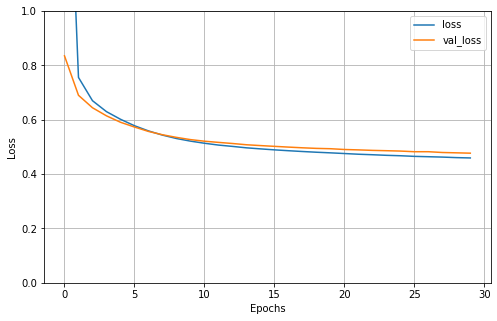

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [20]:
#Same model but with subclassing API

class WideAndDeepModel(keras.Model):
    def __init__(self, units = 30, activation="relu", **kwargs):
        super().__init__(**kwargs) #handles standard args like name
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        return main_output
    
modelSubClass = WideAndDeepModel()

In [22]:
modelSubClass.call([X_train_A, X_train_B])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(11610, 1), dtype=float32, numpy=
array([[ 0.06414867],
       [-0.40794876],
       [ 0.01864006],
       ...,
       [-0.7962624 ],
       [ 0.05521054],
       [ 0.06316879]], dtype=float32)>

In [26]:
import os

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [27]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit((X_train_A, X_train_B), y_train, epochs = 30, validation_data=((X_valid_A, X_valid_B), y_valid), callbacks=[tensorboard_cb])


Epoch 1/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4625 - val_loss: 0.4798
Epoch 2/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4614 - val_loss: 0.4781
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4598 - val_loss: 0.4770
Epoch 4/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4586 - val_loss: 0.4755
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4572 - val_loss: 0.4744
Epoch 6/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4561 - val_loss: 0.4733
Epoch 7/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4550 - val_loss: 0.4725
Epoch 8/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4538 - val_loss: 0.4710
Epoch 9/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4526 - val_loss: 0.4698
Epoch 10/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4512 - val_loss: 0.4687

In [28]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 30172.

In [ ]:
#TensorBoard is still available if you load port 6006 in browser.